# Modal decomposition of a swirling flow (Part 1)

## Create dataset

In [42]:
# HIDE CODE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def phantomGaussian(size, fwhm=3, center=None, scale=1, offset_x=0):
    """Create a Gaussian shape inside a rectangle"""
    x = np.arange(0, size, 1, float)
    R = size // 2
    y = x[:R, np.newaxis]

    if center is None:
        x0 = y0 = R
    else:
        x0 = center[0]
        y0 = center[1]
    output = np.exp(-4*np.log(2) * ((x-x0/scale-offset_x)**2 + (y-y0/scale)**2) / (fwhm/scale)**2)

    return output


def pvc_1(size=128, R=64, fac_x=0.951662, fac_y=0.9222):
    """Create a precessing vortex core with spatial shift"""
    
    v_x_settings = [[-0.7, 35, 0, 0],
                    [-0.4, 20, 30, -2], [-0.4, 20, -30, -2],
                    [1.1, 32, 26, 28], [1.1, 32, -26, 28],
                    [0.4, 18, 48, 28], [0.4, 18, -48, 28],
                    [-0.6, 30, 50, 54], [-0.8, 30, 30, 48], [-0.6, 30, -50, 54], [-0.8, 30, -30, 48]]
    v_x_settings = np.array(v_x_settings)
    v_x_settings[:,2] = v_x_settings[:,2]*fac_x
    v_x_settings[:,3] = v_x_settings[:,3]*fac_x
    v_x = np.zeros([R, size])
    for i in v_x_settings:
        v_x += i[0]*phantomGaussian(size, fwhm=i[1], center=[i[2]+R, i[3]])

    v_y_settings = [[1., 30, 6, 0], [-1., 30, -6, 0], [0.5, 15, 3, 0], [-0.5, 15, -3, 0],
                    [-0.3, 10, 30, 2], [0.3, 10, -30, 2], [-0.5, 10, 30, 12], [0.5, 10, -30, 12],
                    [-1, 30, 25, 40], [1, 30, -25, 40],
                    [0.8, 35, 40, 70], [-0.8, 35, -40, 70],
                    [0.7, 10, 46, 35], [-0.7, 10, -46, 35],
                    [0.3, 10, 43, 20], [-0.3, 10, -43, 20],
                    [-0.1, 30, 60, 10], [0.1, 30, -60, 10]]
    v_y_settings = np.array(v_y_settings)
    v_y_settings[:,2] = v_y_settings[:,2]*fac_y
    v_y_settings[:,3] = v_y_settings[:,3]*fac_y
    v_y = np.zeros([R, size])
    for i in v_y_settings:
        v_y += i[0]*phantomGaussian(size, fwhm=i[1], center=[i[2]+R, i[3]])
    return np.array([v_x*1.078, v_y])


def pvc_2(size=128, R=64, fac_x=1, fac_y=1):
    """Create a precessing vortex core
    """
    v_x_settings = [[0.8, 15, 0, -7],
                    [0.4, 20, 38, -8], [0.4, 20, -38, -8],
                    [-0.7, 35, 17, 12], [-0.7, 35, -17, 12],
                    [-0.6, 20, 36, 12], [-0.6, 20, -36, 12],
                    [1.1, 32, 30, 38], [1.1, 32, -30, 38],
                    [-1, 30, 52, 70], [-1, 30, 34, 70], [-1, 30, -52, 70], [-1, 30, -34, 70]]
    v_x_settings = np.array(v_x_settings)
    v_x_settings[:,2] = v_x_settings[:,2]*fac_x
    v_x_settings[:,3] = v_x_settings[:,3]*fac_x
    v_x = np.zeros([R, size])
    for i in v_x_settings:
        v_x += i[0]*phantomGaussian(size, fwhm=i[1], center=[i[2]+R, i[3]])

    v_y_settings = [[1, 30, 18, 22], [-1, 30, -18, 22],
                    [-0.3, 10, 5, 0], [0.3, 10, -5, 0],
                    [-0.8, 15, 36, 18], [0.8, 15, -36, 18], [-0.6, 15, 32, 2], [0.6, 15, -32, 2],
                    [0.1, 25, 40, -2], [-0.1, 25, -40, -2],
                    [-1, 30, 30, 50], [1, 30, -30, 50],
                    [1, 35, 53, 64], [-1, 35, -53, 64],
                    [-0.3, 30, 75, 20], [0.3, 30, -75, 20]]
    v_y_settings = np.array(v_y_settings)
    v_y_settings[:,2] = v_y_settings[:,2]*fac_y
    v_y_settings[:,3] = v_y_settings[:,3]*fac_y
    v_y = np.zeros([R, size])
    for i in v_y_settings:
        v_y += i[0]*phantomGaussian(size, fwhm=i[1], center=[i[2]+R, i[3]])
    return np.array([v_x, v_y])


def dataset_stationary(func1, func2, N=400, f=470, add_noise=False, noise_level=0.4):
    """
    Create a dataset using either PVC or TV, with a stationary wave-like motion
    """
    np.random.seed(0)
    t = np.arange(N)*1e-4
    v_array = []
    noise = np.zeros([2, 64, 128])
    for _t in t:
        if add_noise:
            noise = np.random.randn(2, 64, 128)*noise_level
        v_array.append(func1*np.cos(2*np.pi*f*_t) + func2*np.sin(2*np.pi*f*_t)+noise)

    return np.array(v_array)

In [14]:
# create dataset
dataset = dataset_stationary(pvc_1(), pvc_2(), N=2000)
# reshape
dataset = np.moveaxis(dataset, [1, 2, 3], [3, 1, 2])


## Setup machine learning model

In [26]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Lambda, Add, Reshape
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split

In [39]:
input_img = Input(shape=(64, 128, 2))
## Encoder
x = Conv2D(16, (3, 3), activation='tanh', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='tanh', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='tanh', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='tanh', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(4, (3, 3), activation='tanh', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(4, (3, 3), activation='tanh', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Reshape([1*2*4])(x)
encoded = Dense(2,activation='tanh')(x)
## Two variables
val1= Lambda(lambda x: x[:,0:1])(encoded)
val2= Lambda(lambda x: x[:,1:2])(encoded)
## Decoder 1
x1 = Dense(1*2*4,activation='tanh')(val1)
x1 = Reshape([1,2,4])(x1)
x1 = UpSampling2D((2,2))(x1)
x1 = Conv2D(4,(3,3),activation='tanh',padding='same')(x1)
x1 = UpSampling2D((2,2))(x1)
x1 = Conv2D(8,(3,3),activation='tanh',padding='same')(x1)
x1 = UpSampling2D((2,2))(x1)
x1 = Conv2D(8,(3,3),activation='tanh',padding='same')(x1)
x1 = UpSampling2D((2,2))(x1)
x1 = Conv2D(8,(3,3),activation='tanh',padding='same')(x1)
x1 = UpSampling2D((2,2))(x1)
x1 = Conv2D(16,(3,3),activation='tanh',padding='same')(x1)
x1 = UpSampling2D((2,2))(x1)
x1d = Conv2D(2,(3,3),activation='linear',padding='same')(x1)
## Decoder 2
x2 = Dense(1*2*4,activation='tanh')(val2)
x2 = Reshape([1,2,4])(x2)
x2 = UpSampling2D((2,2))(x2)
x2 = Conv2D(4,(3,3),activation='tanh',padding='same')(x2)
x2 = UpSampling2D((2,2))(x2)
x2 = Conv2D(8,(3,3),activation='tanh',padding='same')(x2)
x2 = UpSampling2D((2,2))(x2)
x2 = Conv2D(8,(3,3),activation='tanh',padding='same')(x2)
x2 = UpSampling2D((2,2))(x2)
x2 = Conv2D(8,(3,3),activation='tanh',padding='same')(x2)
x2 = UpSampling2D((2,2))(x2)
x2 = Conv2D(16,(3,3),activation='tanh',padding='same')(x2)
x2 = UpSampling2D((2,2))(x2)
x2d = Conv2D(2,(3,3),activation='linear',padding='same')(x2)

decoded = Add()([x1d,x2d])


In [50]:
autoencoder = Model(input_img, decoded)
optimizer = tf.keras.optimizers.Adam(lr=1e-8)
autoencoder.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Check the network structure
autoencoder.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 64, 128, 2)] 0                                            
__________________________________________________________________________________________________
conv2d_84 (Conv2D)              (None, 64, 128, 16)  304         input_7[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_36 (MaxPooling2D) (None, 32, 64, 16)   0           conv2d_84[0][0]                  
__________________________________________________________________________________________________
conv2d_85 (Conv2D)              (None, 32, 64, 8)    1160        max_pooling2d_36[0][0]           
____________________________________________________________________________________________

## Pretraining

- Finding an appropriate learning rate

In [28]:
lr_schedule = LearningRateScheduler(
                 lambda epoch: 1e-8 * 10**(2*epoch / 20))
X_train,X_test,y_train,y_test=train_test_split(dataset, dataset, test_size=0.2,random_state=1)

history=autoencoder.fit(X_train, y_train,
                        epochs=100,
                        batch_size=32,
                        shuffle=True,
                        validation_data=(X_test, y_test),
                        callbacks=[lr_schedule])

Epoch 1/100
50/50 [==============================] - 2s 32ms/step - loss: 0.1821 - mae: 0.3302 - val_loss: 0.1818 - val_mae: 0.3302
Epoch 2/100
50/50 [==============================] - 1s 25ms/step - loss: 0.1812 - mae: 0.3292 - val_loss: 0.1818 - val_mae: 0.3302
Epoch 3/100
50/50 [==============================] - 1s 25ms/step - loss: 0.1815 - mae: 0.3296 - val_loss: 0.1818 - val_mae: 0.3302
Epoch 4/100
50/50 [==============================] - 1s 25ms/step - loss: 0.1816 - mae: 0.3297 - val_loss: 0.1818 - val_mae: 0.3301
Epoch 5/100
50/50 [==============================] - 1s 25ms/step - loss: 0.1817 - mae: 0.3298 - val_loss: 0.1818 - val_mae: 0.3301
Epoch 6/100
50/50 [==============================] - 1s 25ms/step - loss: 0.1816 - mae: 0.3296 - val_loss: 0.1817 - val_mae: 0.3301
Epoch 7/100
50/50 [==============================] - 1s 25ms/step - loss: 0.1816 - mae: 0.3297 - val_loss: 0.1817 - val_mae: 0.3301
Epoch 8/100
50/50 [==============================] - 1s 25ms/step - loss: 0.

(1e-08, 1.0, 0.0, 0.2)

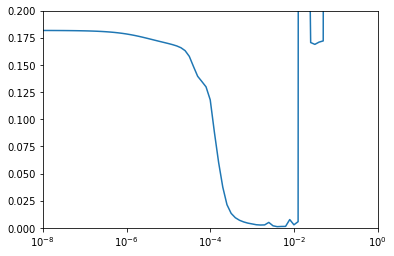

In [34]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1, 0, 0.2])

## Real training


In [40]:
autoencoder = Model(input_img, decoded)
optimizer = tf.keras.optimizers.Adam(lr=2.5e-3)
autoencoder.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

tempfn='./model_1.hdf5'
model_cb=ModelCheckpoint(tempfn, monitor='val_loss',save_best_only=True,verbose=1)
early_cb=EarlyStopping(monitor='val_loss', patience=50,verbose=1)
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                            patience=5,
                                                            verbose=1,
                                                            factor=0.5,
                                                            min_lr=0.00001)
cb = [model_cb, early_cb, learning_rate_reduction]
history=autoencoder.fit(X_train, y_train,
                        epochs=2000,
                        batch_size=32,
                        shuffle=True,
                        validation_data=(X_test, y_test),
                        callbacks=cb)

: val_loss improved from 0.00003 to 0.00003, saving model to ./model_1.hdf5
Epoch 1910/2000
50/50 [==============================] - 1s 25ms/step - loss: 2.6135e-05 - mae: 0.0039 - val_loss: 2.6201e-05 - val_mae: 0.0039

Epoch 01910: val_loss did not improve from 0.00003
Epoch 1911/2000
50/50 [==============================] - 1s 24ms/step - loss: 2.6160e-05 - mae: 0.0039 - val_loss: 2.6191e-05 - val_mae: 0.0039

Epoch 01911: val_loss did not improve from 0.00003
Epoch 1912/2000
50/50 [==============================] - 1s 24ms/step - loss: 2.6149e-05 - mae: 0.0039 - val_loss: 2.6178e-05 - val_mae: 0.0039

Epoch 01912: val_loss improved from 0.00003 to 0.00003, saving model to ./model_1.hdf5
Epoch 1913/2000
50/50 [==============================] - 1s 25ms/step - loss: 2.6139e-05 - mae: 0.0039 - val_loss: 2.6152e-05 - val_mae: 0.0039

Epoch 01913: val_loss improved from 0.00003 to 0.00003, saving model to ./model_1.hdf5
Epoch 1914/2000
50/50 [==============================] - 1s 24ms/ste

## Save history


In [43]:
df_results = pd.DataFrame(history.history)
df_results['epoch'] = history.epoch
tempfn='./model_1.csv'
df_results.to_csv(path_or_buf=tempfn,index=False)

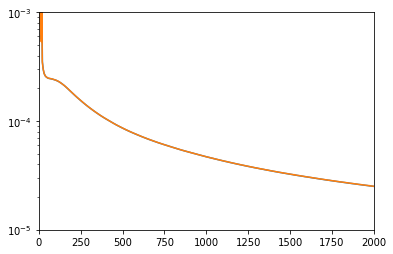

In [49]:
plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])
plt.axis([0, 2000, 1e-5, 1e-3])
plt.show()

## Extract latent space and modes

In [64]:
model = load_model("model_1.hdf5")
model_reduced_1 = Model(inputs=model.input,
                      outputs=model.get_layer("conv2d_95").output)
model_reduced_2 = Model(inputs=model.input,
                      outputs=model.get_layer("conv2d_101").output)
model_coeff_1 = Model(inputs=model.input,
                    outputs=model.get_layer("lambda_8").output)
model_coeff_2 = Model(inputs=model.input,
                    outputs=model.get_layer("lambda_9").output)

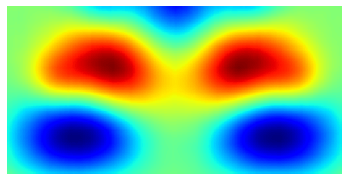

In [61]:
test = model_reduced_1.predict(dataset[np.newaxis, 0, :])
plt.imshow(test[0, :, :, 0], cmap='jet')
plt.axis('off')
plt.savefig("q1.png")
plt.show()

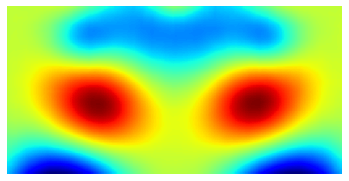

In [65]:
test = model_reduced_2.predict(dataset[np.newaxis, 0, :])
plt.imshow(test[0, :, :, 0], cmap='jet')
plt.axis('off')
plt.savefig("q2.png")
plt.show()

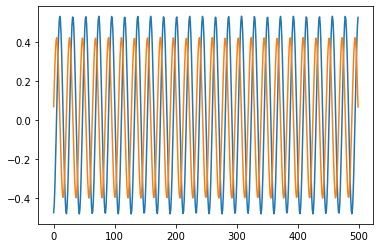

In [66]:
coeff_1 = model_coeff_1.predict(dataset)
coeff_2 = model_coeff_2.predict(dataset)

plt.plot(coeff_1[500:1000])
plt.plot(coeff_2[500:1000])
plt.savefig("r1_r2.png")
plt.show()

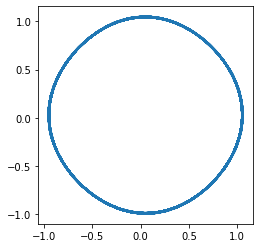

In [79]:
_, ax = plt.subplots(1)
ax.plot(coeff_1/0.5, coeff_2/0.4)
ax.set_aspect(1)
plt.savefig("phase.png")
plt.show()